# Part III: Modelling

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

%matplotlib inline

## 1. Join the two subreddits

In [2]:
dh = pickle.load(open('../data/pickled_depression.csv', 'rb'))
sw = pickle.load(open('../data/pickled_suicide.csv', 'rb'))

In [3]:
dh.shape

(874, 2)

In [4]:
sw.shape

(988, 2)

In [5]:
df = pd.concat([dh,sw], ignore_index=True, join='outer')
df

,subreddit,comtext
0,depression_help,I learned that 78% of suicides are men and peo...
1,depression_help,"Those dark days As I write this, reddit sugges..."
2,depression_help,There's nothing interesting to title this I fe...
3,depression_help,School instantly destroys my mental state I st...
4,depression_help,Yeeeah first shower in...a long time! Yeeeah f...
...,...,...
1857,SuicideWatch,I wanna die but i can’t. My gf told her mom sb...
1858,SuicideWatch,22 female can’t get out of bed Sorry there is ...
1859,SuicideWatch,Posted this in r/Depression. Upon reflection i...
1860,SuicideWatch,i fucking hate psychosis i hate my meds they’v...


#### Create a column for classification

In [6]:
df['suicide'] = [1 if df.loc[i,'subreddit'] == 'SuicideWatch' else 0 for i in range(df.shape[0])]

In [7]:
df

,subreddit,comtext,suicide
0,depression_help,I learned that 78% of suicides are men and peo...,0
1,depression_help,"Those dark days As I write this, reddit sugges...",0
2,depression_help,There's nothing interesting to title this I fe...,0
3,depression_help,School instantly destroys my mental state I st...,0
4,depression_help,Yeeeah first shower in...a long time! Yeeeah f...,0
...,...,...,...
1857,SuicideWatch,I wanna die but i can’t. My gf told her mom sb...,1
1858,SuicideWatch,22 female can’t get out of bed Sorry there is ...,1
1859,SuicideWatch,Posted this in r/Depression. Upon reflection i...,1
1860,SuicideWatch,i fucking hate psychosis i hate my meds they’v...,1


#### Baseline Accuracy - 53%

In [8]:
df.suicide.value_counts(normalize=True)

1    0.530612
0    0.469388
Name: suicide, dtype: float64

## 2. Text Preparation

### Define a function to prepare the text

In [9]:
def info_to_words(raw_info):
    # Function to convert raw info to a string of words
    # The input is astring (raw data), and 
    # the output is also a string (preprocessed data)
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", raw_info)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    # Notice that we did this in one line!
    
    # 3. Convert the stop words to a set to enhance the search spped
    # stops = set(stopwords.words('english'))     # stopwords from nltk
    stops = set(stop_words.ENGLISH_STOP_WORDS)    # stopwords from sklearn
#    stops.update({'depression', 'depressed', 'suicide'})
    
    # 4. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 5. Lemmatize the words
    # Instantiate lemmatizer. (Same as above.)
    lemmatizer = WordNetLemmatizer()
    words_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(words_lem))

In [10]:
# Clean the datas

In [11]:
print("Cleaning and parsing df ...")
clean_text = [info_to_words(i) for i in df['comtext']]

Cleaning and parsing df ...


#### Compare the text before and after clean

In [12]:
df.comtext[1800]

'Nothing Matters I\'ve been trying to ignore a voice in my head, but I just can\'t take it anymore. Every night something  says "kill yourself, kill yourself, kill yourself." THE VOICE NEVER GOES AWAY. Nobody cares about me. My only friend ignores me and my parents are always working. I feel like if I hung myself or slit my own throat nobody would even notice. I can\'t find any reason to live. It\'ll never get better. People say it will, but it never does. If I stop talking, I\'m sorry.'

In [13]:
clean_text[1800]

'matter ve trying ignore voice head just t anymore night say kill kill kill voice go away care friend ignores parent working feel like hung slit throat notice t reason live ll better people say doe stop talking m sorry'

In [14]:
df.suicide.value_counts()

1    988
0    874
Name: suicide, dtype: int64

In [15]:
df['suicide'].shape

(1862,)

In [16]:
len(clean_text)

1862

In [17]:
df.suicide

0       0
1       0
2       0
3       0
4       0
       ..
1857    1
1858    1
1859    1
1860    1
1861    1
Name: suicide, Length: 1862, dtype: int64

## 3. Train Test Split the data

In [18]:
X = clean_text
y = df.suicide

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,
                                                y,
                                                shuffle = True,
                                                random_state = 42,
                                                test_size = 0.3,
                                                stratify=y)

## 4. Modelling

The following models were assessed:
    1. LogisticRegression with 
        - CountVectorizer
        - TfidfVectorizer
    2. Naive Bays Model with
        - CountVectorizer
        - TfidfVectorizer

- Pipeline the vectorizer and the model
- Perform randomizedSearch for the optimal params

* TfidfVectorizer is similar to CoutVectorizer, except It tells us which words are most discriminating between documents.  Common words are penalized, but rare words will have more influence.  I'm curious to know if these two vectorizers will have significant impact on the results.

In [20]:
cvec=CountVectorizer(max_features = 5000)
cvec.fit(X_train)

lr = LogisticRegression()
lr.fit(cvec.transform(X_train), y_train)
lr.score(cvec.transform(X_train), y_train), lr.score(cvec.transform(X_test), y_test)


C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.9877206446661551, 0.7298747763864043)

### LOGISTIC REGRESSION

### 1. LogisticRegression with CountVectorizer

In [21]:
pipe_log = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'cvec__max_features': [500,600,700,800,1000,2000,3000, 3500,5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.8, 0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'lr__penalty':['l1','l2'],
    'lr__class_weight': [None, 'balanced'],
    'lr__solver':['liblinear'],
    'lr__C':[0.1, 0.2,0.3]
}

rs = RandomizedSearchCV(pipe_log, 
                        pipe_params, 
                        cv=5, 
                        n_iter=50, 
                        verbose=1, 
                        n_jobs=-1, 
                        random_state=42)
rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   39.4s finished


0.7651573292402148
{'lr__solver': 'liblinear', 'lr__penalty': 'l1', 'lr__class_weight': None, 'lr__C': 0.2, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 2, 'cvec__max_features': 600, 'cvec__max_df': 0.9}


In [22]:
# Apply the best parameters to the pipeline
logreg = Pipeline([
    ('cvec', CountVectorizer(ngram_range = (1, 2),
                            min_df = 2,
                            max_df = 0.9,
                            max_features = 600)),
    ('lr', LogisticRegression(solver = 'liblinear',
                             penalty = 'l1',
                             class_weight = 'balanced',
                             C = 0.2))
])

logreg.fit(X_train,y_train)
pred = logreg.predict(X_test)
print(classification_report(y_test, pred))

# look at the score on the test data
logreg.score(X_train,y_train), logreg.score(X_test,y_test)

              precision    recall  f1-score   support

           0       0.79      0.68      0.73       262
           1       0.75      0.85      0.79       297

    accuracy                           0.77       559
   macro avg       0.77      0.76      0.76       559
weighted avg       0.77      0.77      0.76       559



(0.8242517267843438, 0.7656529516994633)

In [23]:
cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, columns = ['pred_depressed', 'pred_suicide'], index = ['actual_depressed', 'actual_suicide'] )
cm_df

,pred_depressed,pred_suicide
actual_depressed,177,85
actual_suicide,46,251


In [24]:
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

In [25]:
tp/(fp+tp)

0.7470238095238095

In [26]:
tp/(tp+fn)

0.8451178451178452

### 2. LogisticRegression with TfidfVectorizer

In [27]:
pipe_log = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'tvec__ngram_range': [(1, 1), (1,2), (1,5)],
    'tvec__max_df': [0.8, 0.9,1.0],
    'tvec__min_df': [2,3],
    'tvec__max_features': [500,600,700,800,1000,2000,3000, 3500,5000],
    'tvec__norm': ['l1','l2', None],
    'tvec__sublinear_tf': [False, True],
    'lr__penalty':['l1','l2'],
    'lr__class_weight': [None, 'balanced'],
    'lr__solver':['liblinear'],
    'lr__C':[0.2,0.3,0.4,0.45, 0.5, 0.55, 0.6,0.7, 0.8]
}

rs = RandomizedSearchCV(pipe_log, 
                        pipe_params, 
                        cv=5, 
                        n_iter=50, 
                        verbose=1, 
                        n_jobs=-1, 
                        random_state=42)

rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   50.7s finished


0.7689946277820414
{'tvec__sublinear_tf': False, 'tvec__norm': 'l2', 'tvec__ngram_range': (1, 1), 'tvec__min_df': 2, 'tvec__max_features': 500, 'tvec__max_df': 1.0, 'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__class_weight': 'balanced', 'lr__C': 0.5}


In [28]:
# Apply the best parameters to the pipeline
t_logreg = Pipeline([
    ('tvec', TfidfVectorizer(max_features=500,
                            min_df = 2,
                            max_df = 1.0,
                            norm = 'l2',
                            sublinear_tf = False)),
    ('lr', LogisticRegression(solver = 'liblinear',
                             penalty = 'l2',
                             class_weight = 'balanced',
                             C = 0.5))
])

t_logreg.fit(X_train,y_train)
pred = t_logreg.predict(X_test)
print(classification_report(y_test, pred))

# look at the score on the test data
t_logreg.score(X_train,y_train), t_logreg.score(X_test,y_test)

              precision    recall  f1-score   support

           0       0.74      0.79      0.77       262
           1       0.80      0.76      0.78       297

    accuracy                           0.77       559
   macro avg       0.77      0.78      0.77       559
weighted avg       0.78      0.77      0.77       559



(0.8257866462010744, 0.774597495527728)

In [29]:
cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, columns = ['pred_depressed', 'pred_suicide'], index = ['actual_depressed', 'actual_suicide'] )
cm_df

,pred_depressed,pred_suicide
actual_depressed,207,55
actual_suicide,71,226


The score between train and test data are big, indicating the model overfits.

### NAIVE BAYES MODEL

In [30]:
len(X_train),len(X_test)

(1303, 559)

The columns of X are all integer counts after CountVectorizer, so MultinomialNB is the best choice.

### 3. Naive Bayes with CountVectorizer

In [31]:
cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [500,600,700,800,1000,2000,3000, 3500,5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3), (1,4), (1,5)]
}

cvec_nb_rs = RandomizedSearchCV(cvec_nb, 
                        pipe_params, 
                        cv=5, 
                        n_iter=50, 
                        verbose=1, 
                        n_jobs=-1, 
                        random_state=42)

# Fit and evaluate the model
cvec_nb_rs.fit(X_train, y_train)
print(cvec_nb_rs.best_score_)
print(cvec_nb_rs.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   58.6s finished


0.7820414428242517
{'cvec__ngram_range': (1, 3), 'cvec__min_df': 2, 'cvec__max_features': 1000, 'cvec__max_df': 0.9}


In [32]:
# Apply the best parameters to the pipeline
cvec_nb = Pipeline([
    ('cvec', CountVectorizer(ngram_range=(1, 3),
                             min_df = 2,
                             max_df = 0.95,
                             max_features = 1000,
                            )),
    ('nb', MultinomialNB())
])

# Fit and score the model
cvec_nb.fit(X_train,y_train)
pred = cvec_nb.predict(X_test)
print(classification_report(y_test, pred))

# look at the score on the train and test data
cvec_nb.score(X_train,y_train), cvec_nb.score(X_test,y_test)

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       262
           1       0.81      0.82      0.81       297

    accuracy                           0.80       559
   macro avg       0.80      0.80      0.80       559
weighted avg       0.80      0.80      0.80       559



(0.8457405986185725, 0.7996422182468694)

In [33]:
cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, columns = ['pred_depressed', 'pred_suicide'], index = ['actual_depressed', 'actual_suicide'] )
cm_df

,pred_depressed,pred_suicide
actual_depressed,204,58
actual_suicide,54,243


### 4. Naive Bayes with TfidfVectorizer

In [34]:
pipe_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
    'tvec__max_df': [0.8, 0.9,1.0],
    'tvec__min_df': [2,3],
    'tvec__max_features': [500,600,700,800,1000,2000,3000, 3500,5000],
    'tvec__norm': ['l1','l2', None],
    'tvec__sublinear_tf': [False, True],
}

tvec_nb_rs = RandomizedSearchCV(pipe_nb, 
                        pipe_params, 
                        cv=5, 
                        n_iter=50, 
                        verbose=1, 
                        n_jobs=-1, 
                        random_state=42)

# Fit and evaluate the model
tvec_nb_rs.fit(X_train, y_train)
print(tvec_nb_rs.best_score_)
print(tvec_nb_rs.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   41.4s finished


0.7835763622409824
{'tvec__sublinear_tf': True, 'tvec__norm': 'l2', 'tvec__ngram_range': (1, 2), 'tvec__min_df': 3, 'tvec__max_features': 800, 'tvec__max_df': 0.9}


In [35]:
# Apply the best parameters to the pipeline
tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(ngram_range = (1, 2),
                            max_features=800,
                            min_df = 3,
                            max_df = 0.9,
                            norm = 'l2',
                            sublinear_tf = True)),
    ('nb', MultinomialNB())
])

# Fit and score the model
tvec_nb.fit(X_train,y_train)
pred = tvec_nb.predict(X_test)
print(classification_report(y_test, pred))

# look at the score on the train and test data
tvec_nb.score(X_train,y_train), tvec_nb.score(X_test,y_test)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       262
           1       0.77      0.82      0.80       297

    accuracy                           0.77       559
   macro avg       0.78      0.77      0.77       559
weighted avg       0.78      0.77      0.77       559



(0.8403683806600154, 0.774597495527728)

In [36]:
cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, columns = ['pred_depressed', 'pred_suicide'], index = ['actual_depressed', 'actual_suicide'] )
cm_df

,pred_depressed,pred_suicide
actual_depressed,188,74
actual_suicide,52,245


### Summary

The table below summarizes the performance of each combination of vectorizer and models.

|No.|Model|Train Accuracy|Test Accuracy|f1_score|recall|Specificity|
|---|---|---|---|---|---|---|
|1.|CVec + LogReg|0.82|0.77|0.79|0.85|0.68|
|2.|TfidfVec + LogReg|0.83|0.77|0.78|0.76|0.79|
|3.|CVec + NB|0.84|0.80|0.81|0.81|0.78|
|4.|TfidfVec + NB|0.84|0.77|0.80|0.82|0.72|

#### Observation:
1. Both models are overfitting the data, as train accuracy score is always higher than the test score.
2. Both models only scored in the 77%-80% test accuracy, which means that our models can't accurately predict a post.
3. Naive Bayes model performs slightly better than Logistic Regression in test accuracy though.
3. Naive bayes model performs also better than Logistic Regression in f1_score in general.

The positive is "SuicideWatch". In this case, as our goal is to prevent suicide, **recall** (or **sensitivity**) is used to evaluate the models, which means we'd like to minimize false negative (i.e. avoiding scenario when someone with suicidal thoughts is incorrectly predicted as just having depression, hence a miss case). 

For this reason, combination #1 (CountVectorizer and Logistic Regression) is considered the best model, as it has the highest recall. Its recall and specificity are also farely

### Keywords to predict a SuicideWatch post in the best model

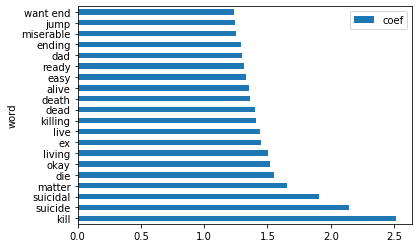

In [37]:
import matplotlib.pyplot as plt
logreg_coef_list = pd.DataFrame(zip(np.exp(logreg[1].coef_[0]),logreg[0].get_feature_names()), columns = ['coef', 'word'])
logreg_coef_list.sort_values("coef", ascending=False).head(20).plot(kind='barh', x='word')
plt.savefig('../images/c_logreg_top_coef.png')

- If someone mentions "kill" in his post, he is 2.5 times as likely to have suicide intent, with all else held equal.
- Other dominant keywords to predict a SuicideWatch post are: suicide, suicidal, and die - which are not surprising.
- Interestingly, a SuicideWatch post will also tend to mention the word "matter", "okay", "ex" and "dad".  The posts likely mention phases like "doesn't matter", "none of it matters", "it's okay", etc. 

## Part IV: Recommendataion

None of the models generalize well. The best model using Countervectorizer and LogisticRegression only has 77% of accuracy and 85% of sensitivity after optimizing both vectorizer and the model.  This can be explained by the similar contents, the high overlaps of the words seen in both subreddits.  In order to have better results, other classifiers such as SVM or Random Forest could be explored.

## Part V: Conclusion

The classifier is able to predict a SuicideWatch post with an accuracy of 77% and sensitivity of 85%, which isn't fantastic. However what is learnt from this project is:
 - 1) If someone mentions "suicide", "suicidal" or "kill", or "die" in a post, we shouldn't ignore the potential of suicidal intention, for very obvious reasons.
 - 2) A suicidal person tends to say things like "doesn't matter", or "it's okay" in his post, which is the exact opposite of the situation.  
 - 3) A suicidal person also seems to mention "ex" and "dad" - as I'm not a domain expert in psychology, but it's natural to guess that father has some sort of influence, and relationship is one of the reasons of suicides.  This can be verified with the domain experts.